In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
# Load the dataset
df_ben_ddos = pd.read_csv('dataset/df_ben_ddos.csv')
df_ben_ddos

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1098,48438,12963,23,1,5.030600,4,1,60,0,0,0
1,1098,33878,59500,23,1,3.089012,4,3,180,0,0,0
2,1098,55416,62742,23,1,3.089276,4,3,180,0,0,0
3,1098,47778,11680,23,1,5.030600,4,1,60,0,0,0
4,1098,46752,1504,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,1097,59699,22203,62336,1,5.030600,0,0,0,0,0,1
2314091,1097,32909,22203,62336,1,5.030600,0,0,0,0,0,1
2314092,1097,25120,22203,62336,1,5.030600,0,0,0,0,0,1
2314093,1097,30340,22203,62336,1,5.030600,0,0,0,0,0,1


In [61]:
# Sample 1% of the dataset
df_sampled = df_ben_ddos.sample(frac=0.01, random_state=42)
df_sampled

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
1301062,1098,31682,52879,992,1,1.697292,3,2,80,0,0,1
37070,1227,18057,58132,53,2,5.030600,4,1,540,0,0,0
1717267,1098,40819,52879,992,1,4.115124,3,7,280,0,0,1
724282,1098,56646,37595,80,1,2.612275,3,2,80,0,0,1
1992155,1098,45359,39426,80,1,5.030600,3,1,40,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
668561,1098,25802,37595,80,1,2.751946,3,3,120,0,0,1
1731172,1098,22926,52879,992,1,3.573725,3,5,200,0,0,1
722738,1098,21217,37595,80,1,3.776339,3,3,120,0,0,1
335712,1098,11038,37595,80,1,2.475084,3,3,120,0,0,1


In [62]:
# Separate features and target labels
X = df_sampled.drop(columns=['Category'])
y = df_sampled['Category']

In [63]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [64]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [65]:
# Define the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

C:\Users\Felipe\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [67]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32,
                    verbose=1)

Epoch 1/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9678 - loss: 0.2356 - val_accuracy: 0.9924 - val_loss: 0.0277
Epoch 2/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9936 - loss: 0.0305 - val_accuracy: 0.9989 - val_loss: 0.0059
Epoch 3/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9980 - loss: 0.0106 - val_accuracy: 0.9989 - val_loss: 0.0041
Epoch 4/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.9989 - val_loss: 0.0030
Epoch 5/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9989 - val_loss: 0.0025
Epoch 6/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9991 - val_loss: 0.0023
Epoch 7/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9998 - val_loss: 0.0020
Epoch 8/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.

In [68]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9997 - loss: 0.0014
Test Loss: 0.0010376512072980404
Test Accuracy: 0.999783992767334


In [69]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


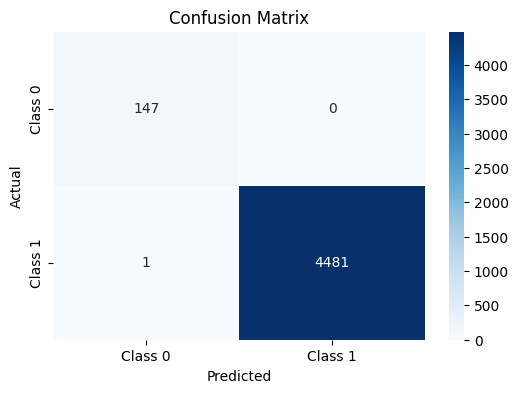

In [70]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [71]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       147
     Class 1       1.00      1.00      1.00      4482

    accuracy                           1.00      4629
   macro avg       1.00      1.00      1.00      4629
weighted avg       1.00      1.00      1.00      4629

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
ROC-AUC Score: 1.00
